In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import shap
import json

In [34]:
#load the data
df1 = pd.read_excel('telecom_data.xlsx')

In [35]:
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


* TotalCharges is stored as an object instead of float64. This likely means there are some non-numeric values (possibly spaces or missing values).should convert it to float64 after handling any inconsistencies.

In [37]:
df1.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


* convert the total Charges data type (obeject) into integer

In [38]:
df1["TotalCharges"] = pd.to_numeric(df1["TotalCharges"], errors='coerce')

* Check any missing values are in total charges

In [39]:
print(df1['TotalCharges'].isnull().sum())

11


* here, 11 missing values we can see so fill that with mean value

In [40]:
df1["TotalCharges"].fillna(df1["TotalCharges"].median(), inplace=True)

<ipython-input-40-14c41a2b680c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1["TotalCharges"].fillna(df1["TotalCharges"].median(), inplace=True)


* Chech duplicates

In [41]:
duplicates = df1.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df1.drop_duplicates()

Number of duplicate rows: 0


In [42]:
print(df1.describe())  # For numeric columns

# Unique values and frequencies for categorical columns
for col in df1.select_dtypes(include=['object']).columns:
    print(f"\nUnique values and frequencies for '{col}':\n{df1[col].value_counts()}")

       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2281.916928
std         0.368612    24.559481       30.090047   2265.270398
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    402.225000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000

Unique values and frequencies for 'customerID':
customerID
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
8775-CEBBJ    1
2823-LKABH    1
             ..
6713-OKOMC    1
1452-KIOVK    1
9305-CDSKC    1
9237-HQITU    1
7795-CFOCW    1
Name: count, Length: 7043, dtype: int64

Unique values and frequencies for 'gender':
gender
Male      3555
Female    3488
Name: count, dtype: int64

Unique values and frequencies for 'Part

In [43]:
# Distribution of the target variable 'Churn'
print(f"\nDistribution of 'Churn':\n{df1['Churn'].value_counts(normalize=True)}")


Distribution of 'Churn':
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


# **From the dataset summary:**

**1. Churn Distribution:**

**No (Stayed):** 5,174 customers

**Yes (Churned):** 1,869 customers

**Class Imbalance:** Churn rate ~26.5% (can affect model performance).

**2.Key Features:**

Numerical Features (e.g., Tenure, MonthlyCharges, TotalCharges)

Categorical Features (e.g., Contract, PaymentMethod, InternetService)

Binary Features (e.g., Gender, Partner, Dependents)

## **EDA**

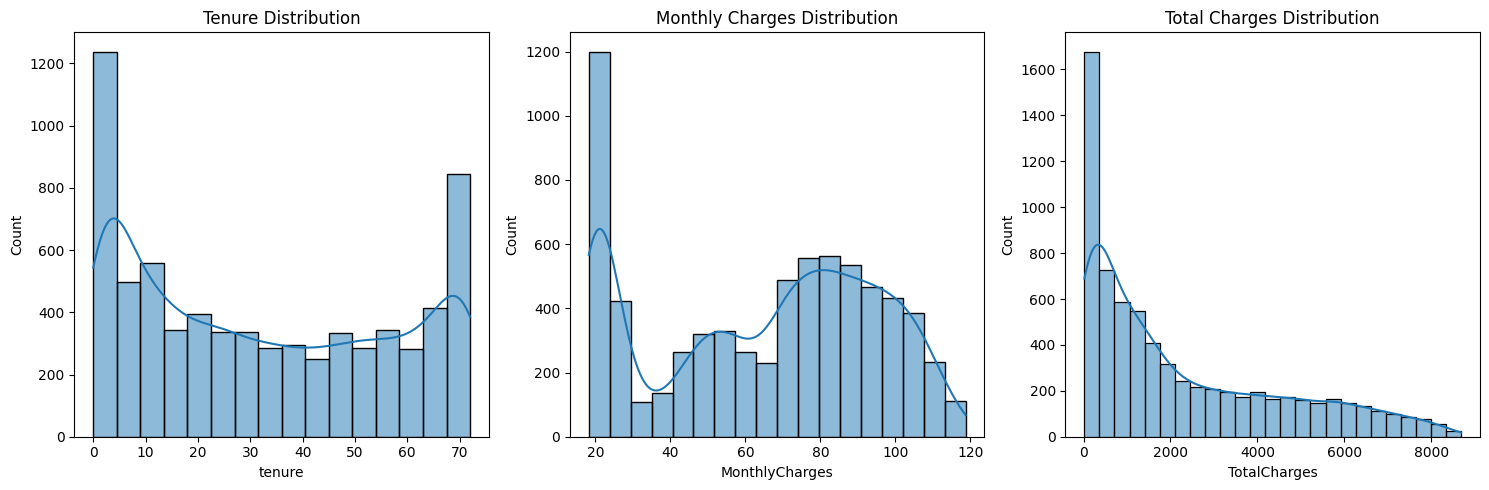

In [44]:
# Histograms for numerical features
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df1['tenure'], kde=True)
plt.title('Tenure Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df1['MonthlyCharges'], kde=True)
plt.title('Monthly Charges Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df1['TotalCharges'].dropna(), kde=True) # dropna to handle potential NaN after conversion
plt.title('Total Charges Distribution')

plt.tight_layout()
plt.show()

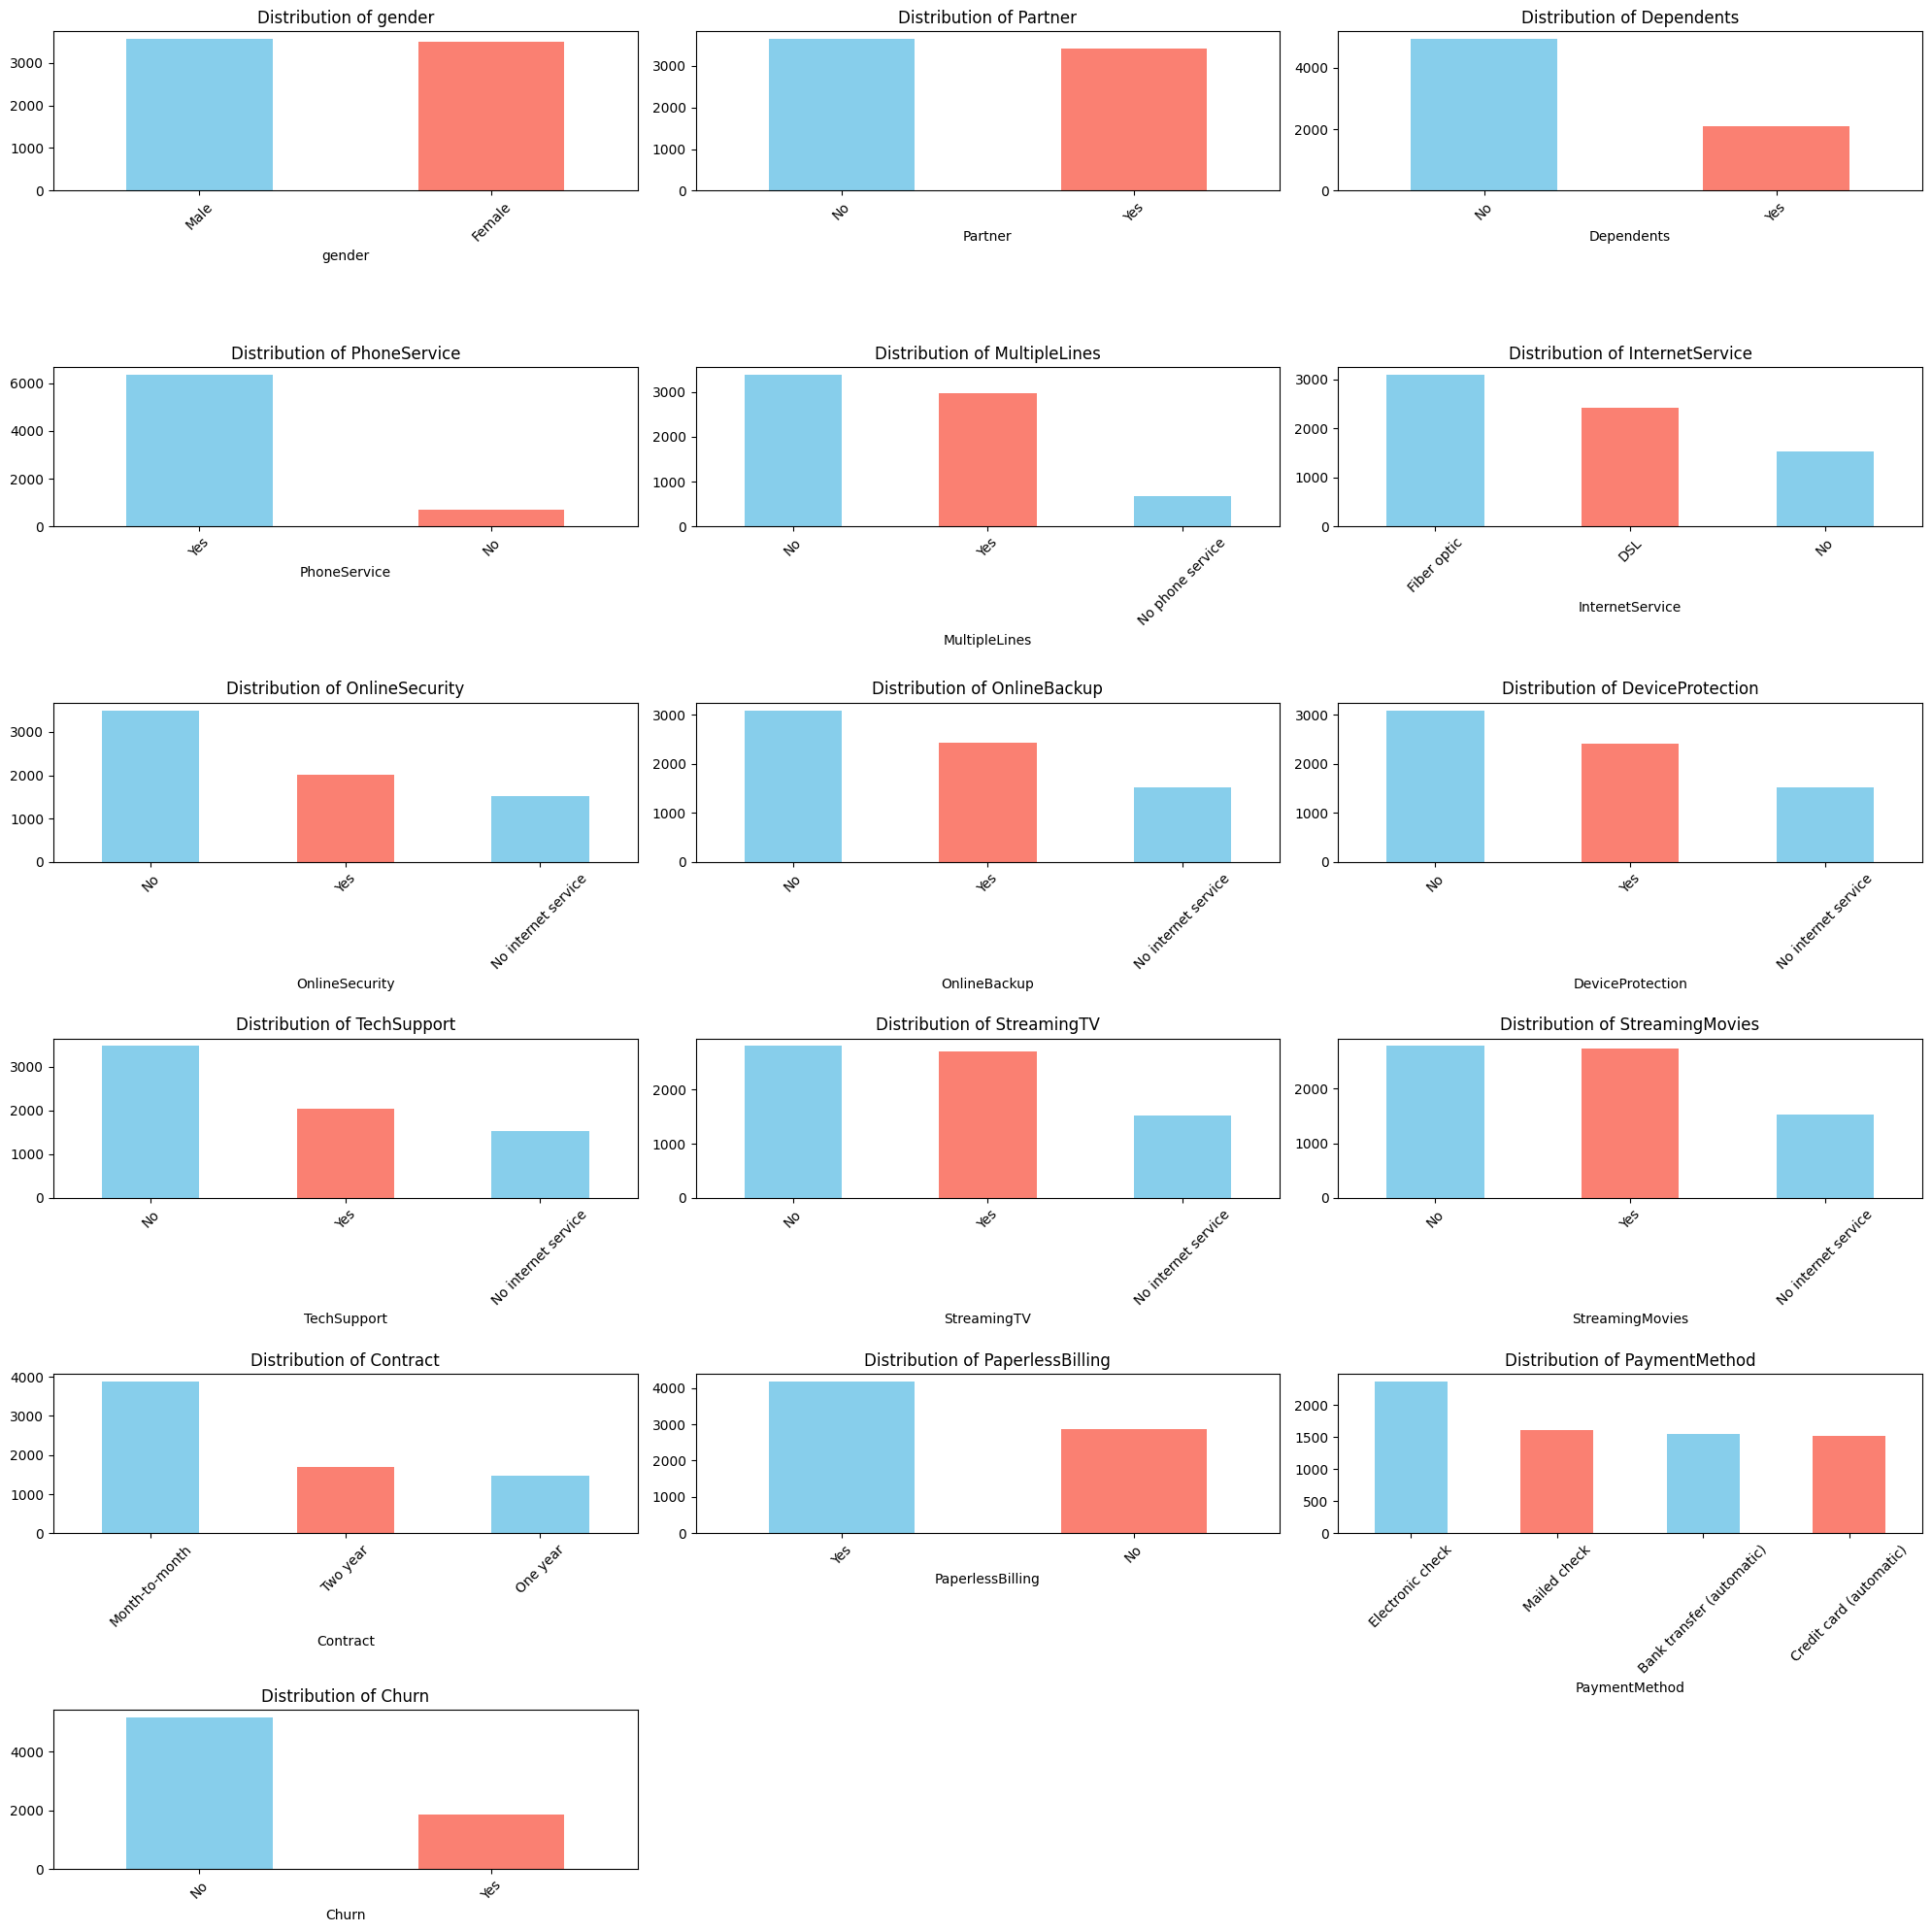

In [46]:
# Bar charts for categorical features
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

plt.figure(figsize=(20, 20))
for i, col in enumerate(categorical_cols):
    plt.subplot(6, 3, i + 1)
    df1[col].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

<ipython-input-47-cf9e6d829f1c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='tenure', data=df1, palette="Set3")
<ipython-input-47-cf9e6d829f1c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=df1, palette="Set3")
<ipython-input-47-cf9e6d829f1c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='TotalCharges', data=df1, palette="Set3")


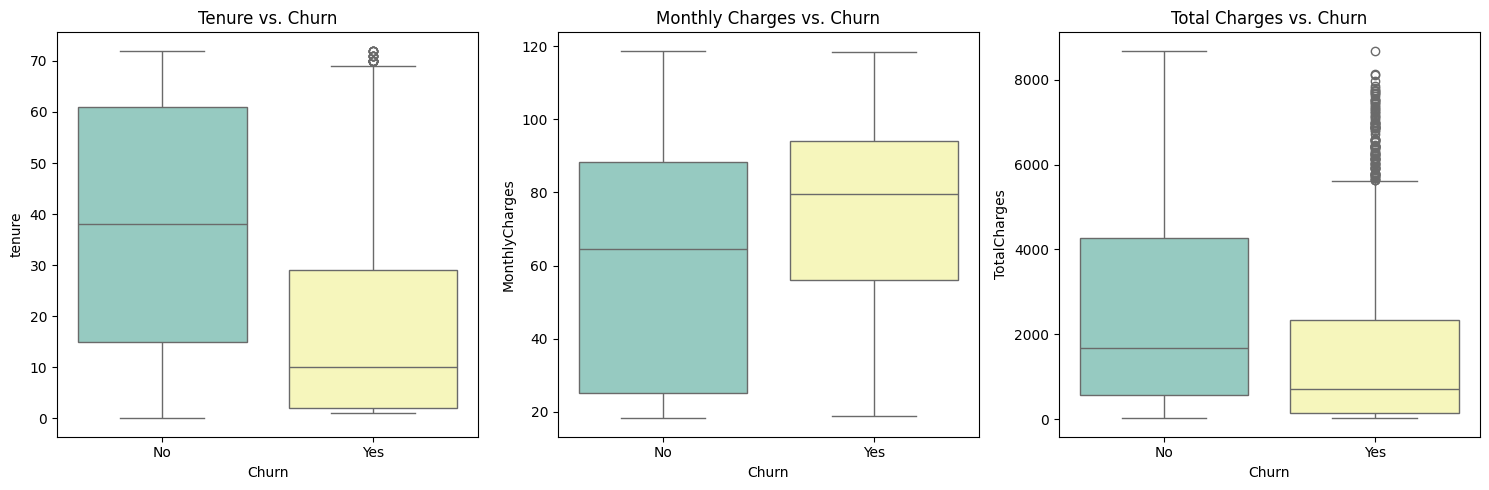

In [47]:
# Boxplots for numerical features vs. Churn
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Churn', y='tenure', data=df1, palette="Set3")
plt.title('Tenure vs. Churn')

plt.subplot(1, 3, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df1, palette="Set3")
plt.title('Monthly Charges vs. Churn')

plt.subplot(1, 3, 3)
sns.boxplot(x='Churn', y='TotalCharges', data=df1, palette="Set3")
plt.title('Total Charges vs. Churn')

plt.tight_layout()
plt.show()


Churn Rates for gender:
Churn          No        Yes
gender                      
Female  73.079128  26.920872
Male    73.839662  26.160338


<Figure size 1000x600 with 0 Axes>

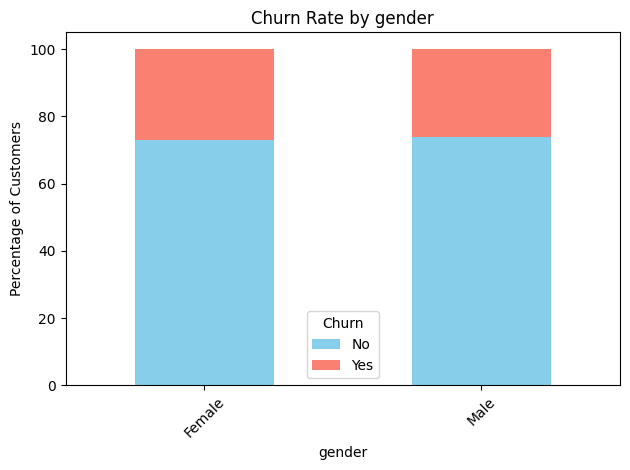


Churn Rates for Partner:
Churn           No        Yes
Partner                      
No       67.042021  32.957979
Yes      80.335097  19.664903


<Figure size 1000x600 with 0 Axes>

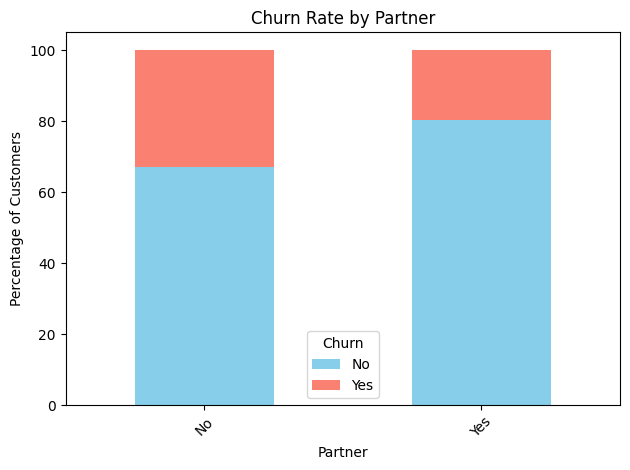


Churn Rates for Dependents:
Churn              No        Yes
Dependents                      
No          68.720860  31.279140
Yes         84.549763  15.450237


<Figure size 1000x600 with 0 Axes>

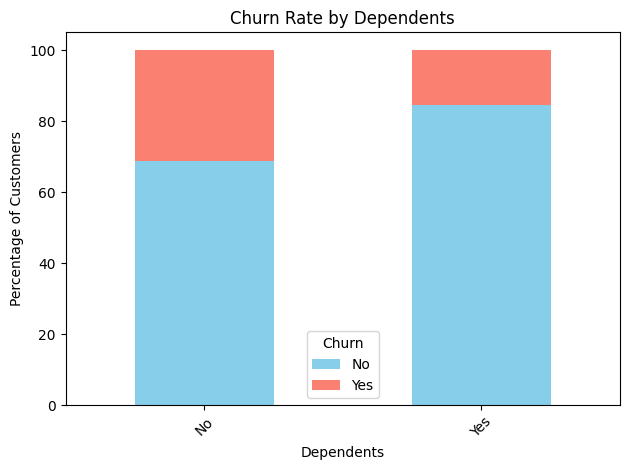


Churn Rates for PhoneService:
Churn                No        Yes
PhoneService                      
No            75.073314  24.926686
Yes           73.290363  26.709637


<Figure size 1000x600 with 0 Axes>

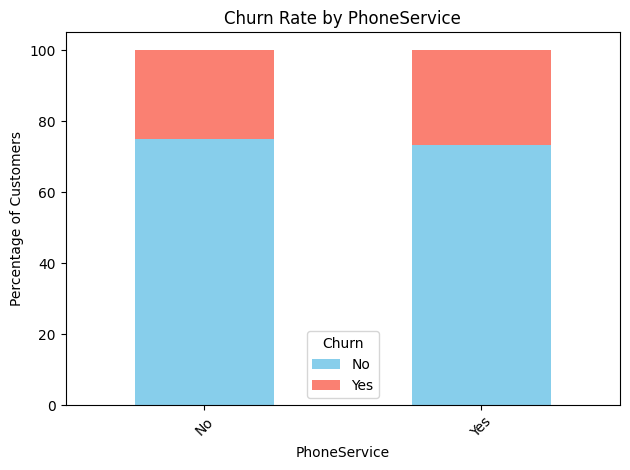


Churn Rates for MultipleLines:
Churn                    No        Yes
MultipleLines                         
No                74.955752  25.044248
No phone service  75.073314  24.926686
Yes               71.390104  28.609896


<Figure size 1000x600 with 0 Axes>

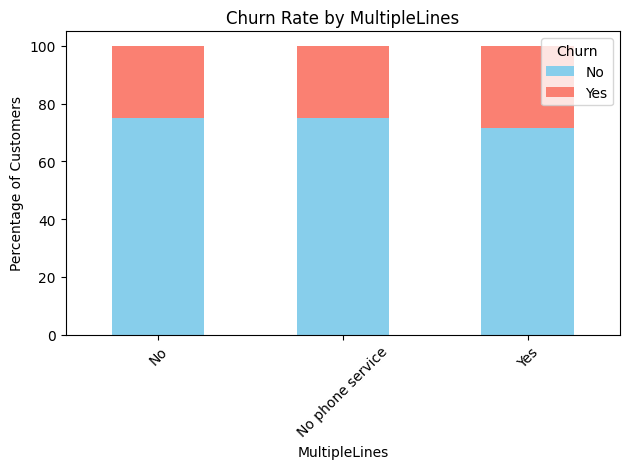


Churn Rates for InternetService:
Churn                   No        Yes
InternetService                      
DSL              81.040892  18.959108
Fiber optic      58.107235  41.892765
No               92.595020   7.404980


<Figure size 1000x600 with 0 Axes>

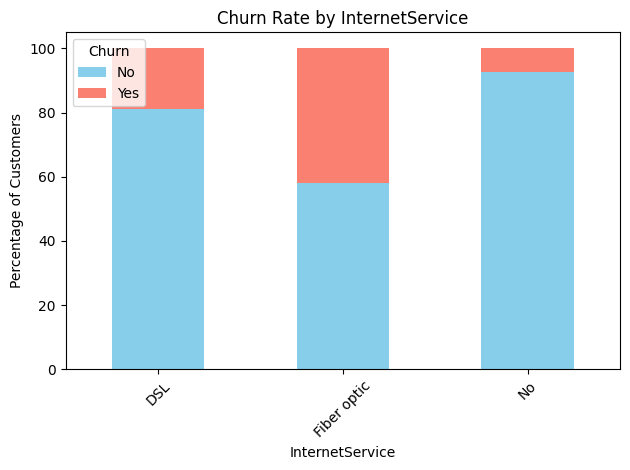


Churn Rates for OnlineSecurity:
Churn                       No        Yes
OnlineSecurity                           
No                   58.233276  41.766724
No internet service  92.595020   7.404980
Yes                  85.388806  14.611194


<Figure size 1000x600 with 0 Axes>

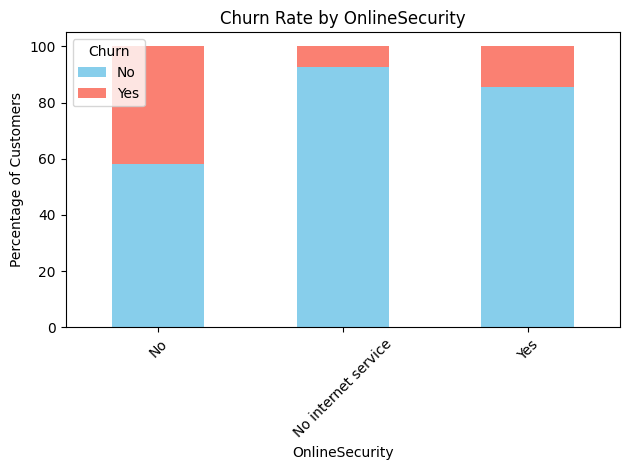


Churn Rates for OnlineBackup:
Churn                       No        Yes
OnlineBackup                             
No                   60.071244  39.928756
No internet service  92.595020   7.404980
Yes                  78.468506  21.531494


<Figure size 1000x600 with 0 Axes>

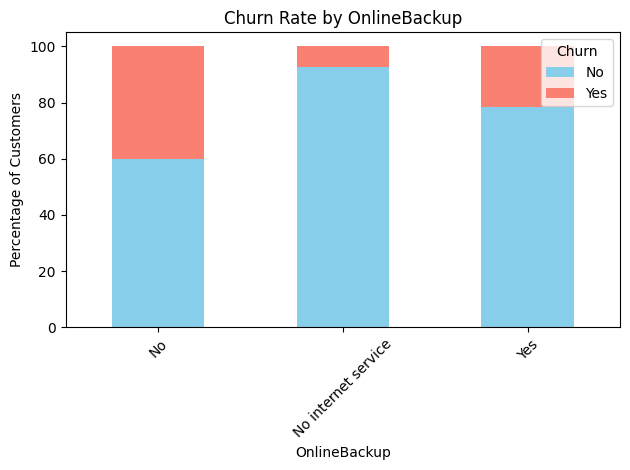


Churn Rates for DeviceProtection:
Churn                       No        Yes
DeviceProtection                         
No                   60.872375  39.127625
No internet service  92.595020   7.404980
Yes                  77.497936  22.502064


<Figure size 1000x600 with 0 Axes>

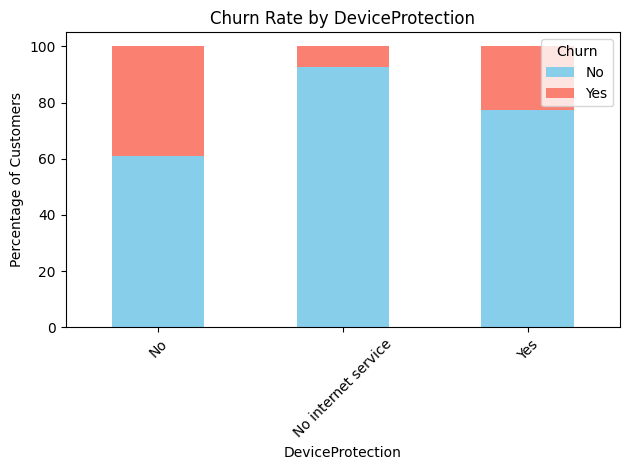


Churn Rates for TechSupport:
Churn                       No        Yes
TechSupport                              
No                   58.364526  41.635474
No internet service  92.595020   7.404980
Yes                  84.833659  15.166341


<Figure size 1000x600 with 0 Axes>

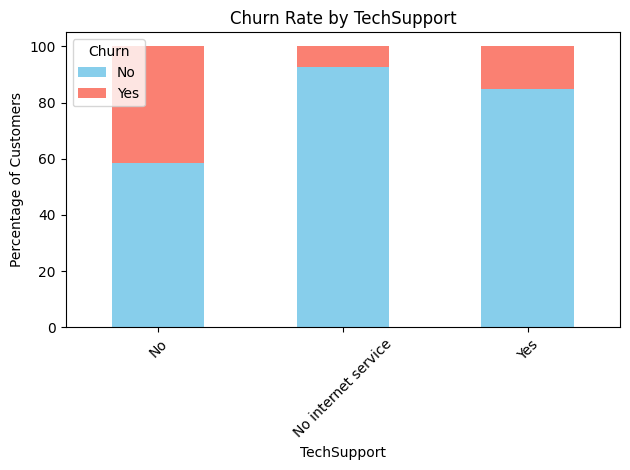


Churn Rates for StreamingTV:
Churn                       No        Yes
StreamingTV                              
No                   66.476868  33.523132
No internet service  92.595020   7.404980
Yes                  69.929812  30.070188


<Figure size 1000x600 with 0 Axes>

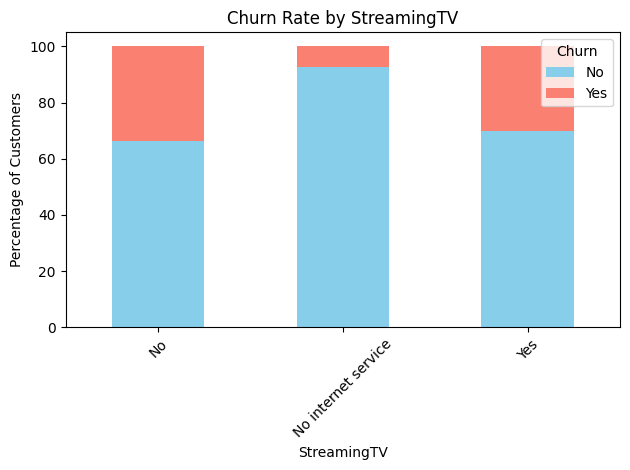


Churn Rates for StreamingMovies:
Churn                       No        Yes
StreamingMovies                          
No                   66.319569  33.680431
No internet service  92.595020   7.404980
Yes                  70.058565  29.941435


<Figure size 1000x600 with 0 Axes>

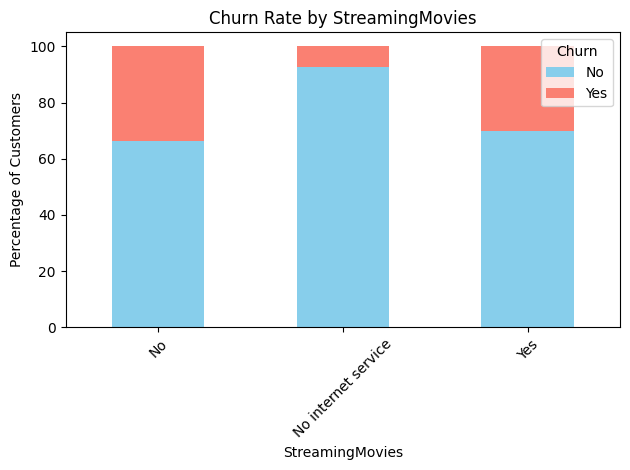


Churn Rates for Contract:
Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858


<Figure size 1000x600 with 0 Axes>

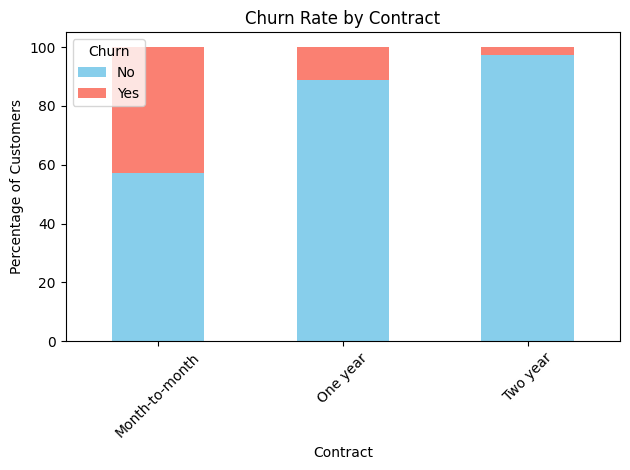


Churn Rates for PaperlessBilling:
Churn                    No        Yes
PaperlessBilling                      
No                83.669916  16.330084
Yes               66.434908  33.565092


<Figure size 1000x600 with 0 Axes>

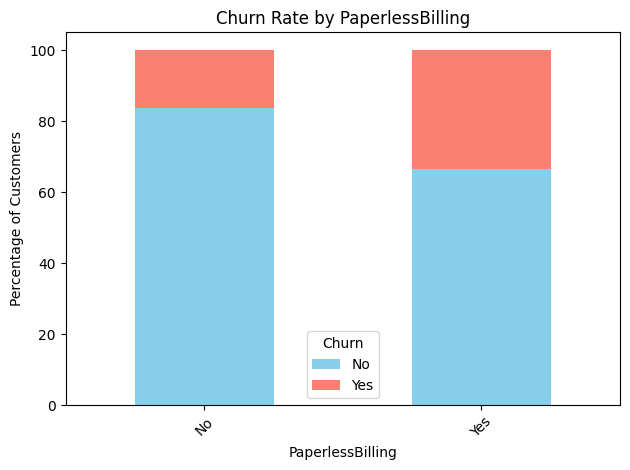


Churn Rates for PaymentMethod:
Churn                             No        Yes
PaymentMethod                                  
Bank transfer (automatic)  83.290155  16.709845
Credit card (automatic)    84.756899  15.243101
Electronic check           54.714588  45.285412
Mailed check               80.893300  19.106700


<Figure size 1000x600 with 0 Axes>

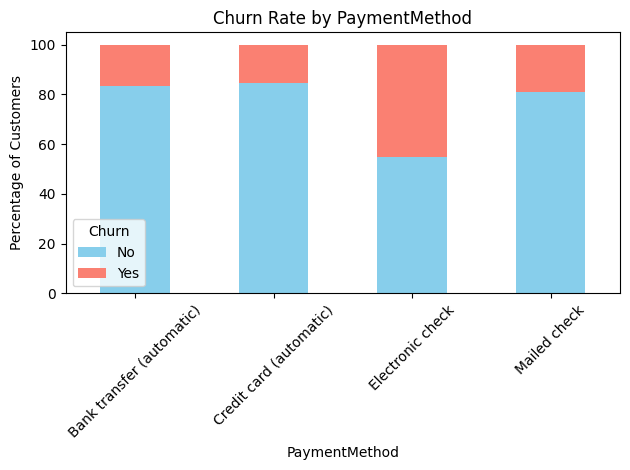

In [48]:
#Categorical Feature Analysis
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in categorical_features:
    churn_rates = df1.groupby(col)['Churn'].value_counts(normalize=True).unstack() * 100
    print(f"\nChurn Rates for {col}:\n{churn_rates}")

    plt.figure(figsize=(10, 6))
    churn_rates.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Percentage of Customers')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend(title='Churn')
    plt.tight_layout()
    plt.show()

# **Data Analysis Key Findings**

**High Churn Rate for Fiber Optic Internet:** Customers with 'Fiber optic' internet service had a significantly higher churn rate compared to those with DSL or no internet service.

**Month-to-Month Contracts and Churn:** Customers with 'Month-to-month' contracts showed a much higher churn rate than those with one-year or two-year contracts.

**Electronic Check Payment Method Correlation:** The 'Electronic check' payment method is correlated with a higher churn rate.

**Tenure Difference:** Churned customers had significantly shorter tenure than non-churned customers.

**Monthly Charges and Churn:** Churned customers tended to have higher monthly charges.

**Total Charges Discrepancy:** 'TotalCharges' were lower for churned customers, suggesting a potential difference in distribution that warrants further investigation.

In [49]:
#Statistical testing: Perform statistical tests (e.g., chi-squared tests for categorical variables, t-tests or ANOVA for numerical variables) to confirm the significance of the observed relationships between variables and churn.

import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

# Chi-squared tests for categorical features
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

for col in categorical_cols:
    contingency_table = pd.crosstab(df1[col], df1['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-squared test for '{col}':")
    print(f"Chi2 statistic: {chi2:.3f}")
    print(f"P-value: {p:.3f}")
    if p < 0.05:
        print("Significant association between", col, "and Churn.")
    else:
        print("No significant association between", col, "and Churn.")


# T-tests or ANOVA for numerical features
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numerical_cols:
    churn_yes = df1[df1['Churn'] == 'Yes'][col]
    churn_no = df1[df1['Churn'] == 'No'][col]
    if len(churn_yes.unique()) > 2 or len(churn_no.unique()) > 2:
        fvalue, pvalue = f_oneway(churn_yes, churn_no)  # ANOVA for more than two groups
        print(f"\nANOVA test for '{col}':")
    else:
        t_statistic, p_value = ttest_ind(churn_yes, churn_no)
        print(f"\nT-test for '{col}':")

    print(f"T-statistic/F-value: {fvalue:.3f}")
    print(f"P-value: {pvalue:.3f}")

    if pvalue < 0.05:
        print("Significant difference in", col, "between churned and non-churned customers.")
    else:
        print("No significant difference in", col, "between churned and non-churned customers.")



Chi-squared test for 'gender':
Chi2 statistic: 0.484
P-value: 0.487
No significant association between gender and Churn.

Chi-squared test for 'Partner':
Chi2 statistic: 158.733
P-value: 0.000
Significant association between Partner and Churn.

Chi-squared test for 'Dependents':
Chi2 statistic: 189.129
P-value: 0.000
Significant association between Dependents and Churn.

Chi-squared test for 'PhoneService':
Chi2 statistic: 0.915
P-value: 0.339
No significant association between PhoneService and Churn.

Chi-squared test for 'MultipleLines':
Chi2 statistic: 11.330
P-value: 0.003
Significant association between MultipleLines and Churn.

Chi-squared test for 'InternetService':
Chi2 statistic: 732.310
P-value: 0.000
Significant association between InternetService and Churn.

Chi-squared test for 'OnlineSecurity':
Chi2 statistic: 849.999
P-value: 0.000
Significant association between OnlineSecurity and Churn.

Chi-squared test for 'OnlineBackup':
Chi2 statistic: 601.813
P-value: 0.000
Signi

# **Statistical Analysis Summary (Chi-Squared & ANOVA)**

**Key Insights from Chi-Squared Tests:**

* No significant relationship with Churn:

* Gender (p=0.487)


* PhoneService (p=0.339)

* Strongly significant factors influencing Churn (p<0.001):
Partner, Dependents, MultipleLines
InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport
StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod

**Key Insights from ANOVA Tests (Numerical Features):**

* Tenure - Customers with shorter tenure are more likely to churn.

* Monthly Charges - Higher monthly charges are linked to higher churn rates.

* Total Charges - Lower total charges indicate higher churn risk, likely due to new customers leaving

# **Feature Selection & Data Preprocessing for ML Model Evaluation**

* Dropping unimportant features (based on chi-squared & ANOVA results).

* Converting categorical features into numerical (0,1,2, etc.).

* Preparing the dataset for ML model evaluation.

**Step 1: Drop Unimportant Features**

* Remove customerID -> Not useful for prediction.

* Drop PhoneService -> No significant impact on churn (p-value > 0.05).

**Step 2: Convert Categorical Data to Numerical**

**Binary Categories (Yes/No → 0/1):**

* Convert the following columns to 0 = No, 1 = Yes:

* Partner, Dependents, PaperlessBilling, Churn
OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport
StreamingTV, StreamingMovies

* Gender: Male = 0, Female = 1

**Multi-Class Categories (Convert to 0,1,2, etc.):**

**Use Label Encoding for:**

* InternetService: No (0), DSL (1), Fiber optic (2)

* Contract: Month-to-month (0), One year (1), Two year (2)

* MultipleLines : No (0), Yes (1), No phone service (2)

* PaymentMethod: Convert to numerical categories

**Numeric Columns (Keep As-Is):**

* Tenure, MonthlyCharges, TotalCharges (already numerical)

In [50]:
df1.drop('customerID', axis=1, inplace=True)

In [51]:
df1.drop('PhoneService', axis=1, inplace=True)

In [52]:
df2 = df1.copy()

In [53]:
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [54]:
# Binary Categories (Yes/No → 1/0)
binary_cols = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in binary_cols:
    df2[col] = df2[col].map({'No': 0, 'Yes': 1})

df2['gender'] = df2['gender'].map({'Male': 0, 'Female': 1})

# Multi-Class Categories
df2['InternetService'] = df2['InternetService'].map({'No': 0, 'DSL': 1, 'Fiber optic': 2})
df2['Contract'] = df2['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df2['MultipleLines'] = df2['MultipleLines'].map({'No': 0, 'Yes': 1, 'No phone service': 2})

# PaymentMethod (Label Encoding)
payment_method_mapping = {label: idx for idx, label in enumerate(df1['PaymentMethod'].unique())}
df2['PaymentMethod'] = df2['PaymentMethod'].map(payment_method_mapping)

In [55]:
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,2,1,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,29.85,29.85,0
1,0,0,0,0,34,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1,0,1,56.95,1889.50,0
2,0,0,0,0,2,0,1,1.0,1.0,0.0,0.0,0.0,0.0,0,1,1,53.85,108.15,1
3,0,0,0,0,45,2,1,1.0,0.0,1.0,1.0,0.0,0.0,1,0,2,42.30,1840.75,0
4,1,0,0,0,2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,70.70,151.65,1


In [56]:
df2.dtypes

,0
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
MultipleLines,int64
InternetService,int64
OnlineSecurity,float64
OnlineBackup,float64
DeviceProtection,float64


In [57]:
# Convert float64 binary columns to int64
binary_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection",
               "TechSupport", "StreamingTV", "StreamingMovies"]

# Replace NaN with 0 before converting to int64
df2[binary_cols] = df2[binary_cols].fillna(0).astype("int64")

# Verify data types
print(df2.dtypes)

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object


# **correlation analysis**

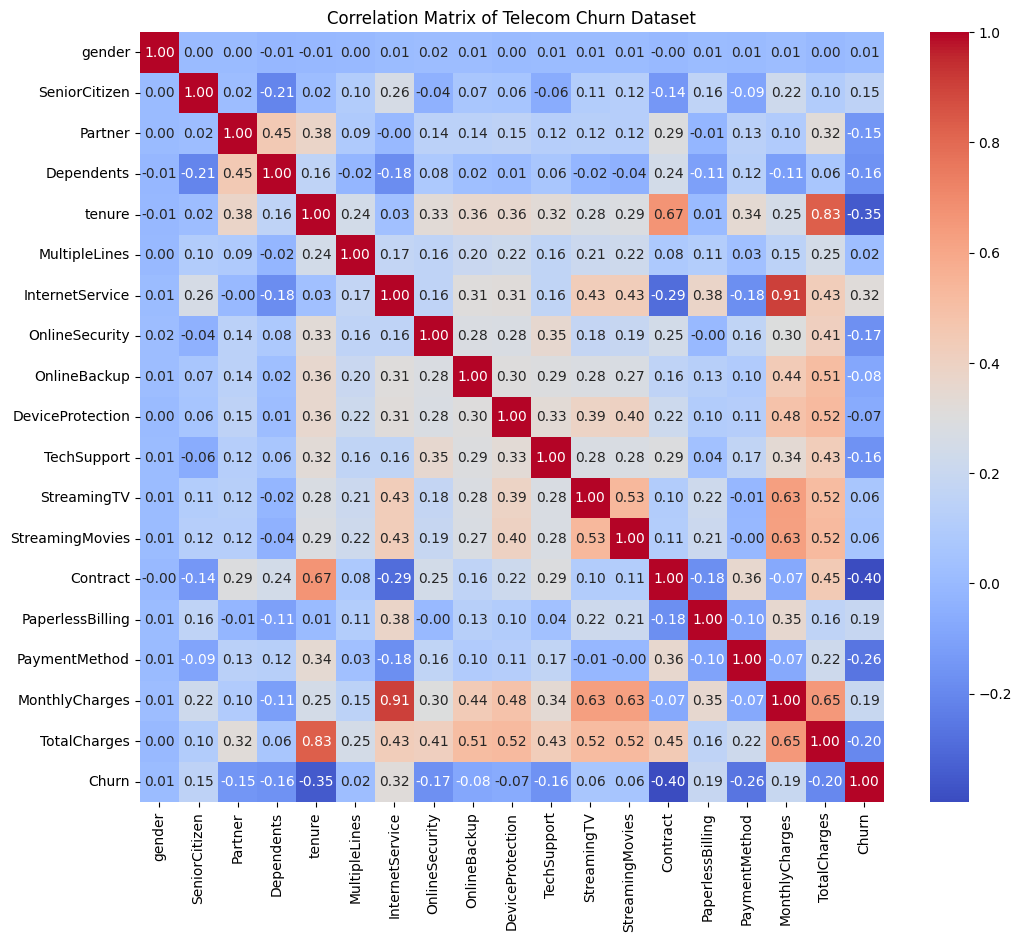

In [58]:
# Correlation analysis plot for df1
plt.figure(figsize=(12, 10))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Telecom Churn Dataset')
plt.show()

# **Key Takeaways:**

**Top Features Correlated with Churn (Negative Correlation - Higher Retention):**


Tenure (-0.35): Longer-tenured customers are less likely to churn.

Partner (-0.15) & Dependents (-0.16): Customers with family or partners are less likely to churn.

OnlineSecurity (-0.17) & TechSupport (-0.16): Customers with security and tech support services tend to stay.

**Top Features Positively Correlated with Churn (Higher Churn Risk):**

Contract (-0.40, inverse relation): Month-to-month contracts have higher churn, while long-term contracts reduce churn.

PaperlessBilling (0.19): Customers with paperless billing tend to churn more.

MonthlyCharges (0.19) & PaymentMethod (0.19): Higher charges and certain payment methods (e.g., electronic check) are linked to higher churn.

**Features with Weak Correlation:**

Gender (0.01) has no significant impact.

StreamingTV & StreamingMovies (0.06) have a very weak relationship with churn.

**Feature Selection Insights:**

* Strong Predictors: Tenure, Contract Type, OnlineSecurity, TechSupport, MonthlyCharges.

* Potentially Drop: Gender, StreamingTV, StreamingMovies (low impact).

In [59]:
df2.drop(['PaperlessBilling', 'gender','Dependents','MultipleLines', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies'],axis=1,inplace=True)

In [60]:
df2.head()

,SeniorCitizen,Partner,tenure,InternetService,TechSupport,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,1,1,0,0,0,29.85,29.85,0
1,0,0,34,1,0,1,1,56.95,1889.50,0
2,0,0,2,1,0,0,1,53.85,108.15,1
3,0,0,45,1,1,1,2,42.30,1840.75,0
4,0,0,2,2,0,0,0,70.70,151.65,1


In [62]:
# Define features and target variable
X = df2.drop(columns=["Churn"])
y = df2["Churn"]

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [63]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Convert to dictionary
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print("Computed Class Weights:", class_weight_dict)


Computed Class Weights: {np.int64(0): np.float64(0.6805991785455424), np.int64(1): np.float64(1.8842809364548494)}


In [65]:
# Logistic Regression
log_reg = LogisticRegression(class_weight={0: 0.6805, 1: 1.8842}, random_state=42)
log_reg.fit(X_train, y_train)

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(class_weight={0: 0.6805, 1: 1.8842}, random_state=42)
dt_clf.fit(X_train, y_train)

# Random Forest Classifier
rf_clf = RandomForestClassifier(class_weight={0: 0.6805, 1: 1.8842}, n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# xgboost classifier
xgb_clf = XGBClassifier(class_weight={0: 0.6805, 1: 1.8842}, random_state=42)
xgb_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:19:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 0.6805, 1: 1.8842}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [66]:
# Train Models
log_reg.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

# Predictions & Probabilities
y_pred_log = log_reg.predict(X_test)
y_pred_dt = dt_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]
y_pred_proba_dt = dt_clf.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Model Evaluation
print("\n Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_log))

print("\n Decision Tree Performance:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_dt))

print("\n Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_rf))

print("\n XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:20:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1035
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.75      1409

ROC-AUC: 0.8335968379446639

 Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1035
           1       0.47      0.47      0.47       374

    accuracy                           0.72      1409
   macro avg       0.64      0.64      0.64      1409
weighted avg       0.72      0.72      0.72      1409

ROC-AUC: 0.6410757188250794

 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                     

# **Key Insights from Model Performance**

**XGBoost (Best Overall Performance):**

* Accuracy: 79%

* ROC-AUC: 0.8279

* Strong precision & recall balance.

**Logistic Regression (Best Recall for Class 1 - Churn):**

* Accuracy: 73%

* ROC-AUC: 0.8336 (Best overall AUC)

* Best recall (0.79) for churn cases, meaning it catches more churners.

**Random Forest (Good Accuracy but Lower Recall for Churn):**

* Accuracy: 78%

* ROC-AUC: 0.8097

* Less effective at identifying churners.

**Decision Tree (Weakest Model, Least Generalizable):**

* Accuracy: 72%

* ROC-AUC: 0.6410

* Not recommended for deployment.

***So, improve the xgboost model with hyperparameter tuning***

In [67]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'scale_pos_weight': [1, 2, 3]  # Balancing class weights
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the best model
best_xgb = xgb.XGBClassifier(**best_params, objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
best_xgb.fit(X_train, y_train)

# Predictions
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Model Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2}
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.83      1035
           1       0.55      0.75      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

ROC-AUC Score: 0.8409504249657703


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:26:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:26:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


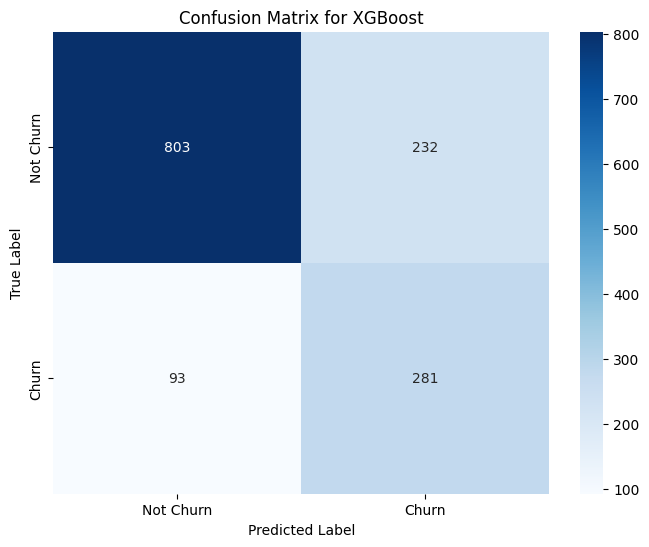

In [68]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Churn", "Churn"],
            yticklabels=["Not Churn", "Churn"])
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **XGBoost Confusion Matrix provides key insights:**

* True Negatives (803) - Correctly predicted "Not Churn" customers.

* True Positives (281) - Correctly predicted "Churn" customers.

* False Negatives (93) - Missed churners (customers who actually churned but were predicted as not churn).

* False Positives (232) - Over-predicted churn (customers predicted to churn but actually stayed).

# **What This Means?**

* Recall for Churners = 75% (281 / (281 + 93)) -> Good at detecting churners.

* Precision for Churners = 55% (281 / (281 + 232)) -> Some non-churners are wrongly classified.

* F1-Score Balancing Precision & Recall is stable, but precision could be improved.

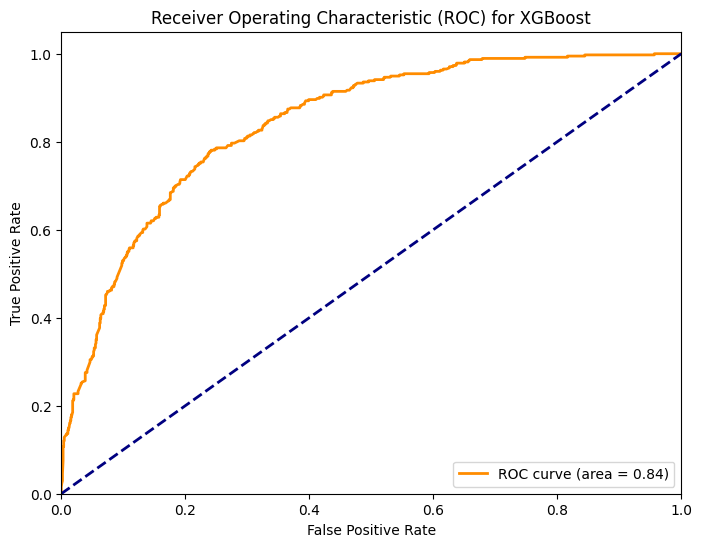

In [69]:
# Get the predicted probabilities for XGBoost
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for XGBoost')
plt.legend(loc="lower right")
plt.show()


# **Save the XGBoost Model**

In [70]:
best_xgb.save_model("xgb_model.json")

print("Model saved to xgb_model.json")

Model saved to xgb_model.json


In [71]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

# Load the trained XGBoost model
model = best_xgb
model.load_model("xgb_model.json")

# Get the feature names the model was trained on
# Assuming 'X_train' was the training data used to fit 'xgb_model'
training_features = X_train.columns.tolist()

# Preprocess data (ensure it matches model training format)
customer_selected = df2[training_features]  # Use all training features
scaler = MinMaxScaler()
customer_scaled = scaler.fit_transform(customer_selected)

# Predict churn probability
df2['churn_probability'] = model.predict_proba(customer_scaled)[:, 1]

# Define risk categories
def assign_risk(prob):
    if prob < 0.5:
        return "Loyal Customer"
    elif prob < 0.6:
        return "Moderate Risk"
    else:
        return "High Risk"

df2['churn_prediction'] = model.predict(customer_selected)
df2['risk_segment'] = df2['churn_probability'].apply(assign_risk)

# Save segmented customers for retention strategies
df2.to_csv("customer_churn_segments.csv", index=False)
print("Customer segmentation completed. Data saved!")

Customer segmentation completed. Data saved!


In [72]:
prediction = pd.read_csv('customer_churn_segments.csv')

In [73]:
prediction.head()

,SeniorCitizen,Partner,tenure,InternetService,TechSupport,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_probability,churn_prediction,risk_segment
0,0,1,1,1,0,0,0,29.85,29.85,0,0.524601,1,Moderate Risk
1,0,0,34,1,0,1,1,56.95,1889.50,0,0.524601,0,Moderate Risk
2,0,0,2,1,0,0,1,53.85,108.15,1,0.524601,1,Moderate Risk
3,0,0,45,1,1,1,2,42.30,1840.75,0,0.538026,0,Moderate Risk
4,0,0,2,2,0,0,0,70.70,151.65,1,0.720484,1,High Risk
